# Import the necessary modules 

In [1]:
import torch
import gym
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
env = gym.make('Blackjack-v0')

use on-policy for choosing action

In [2]:
def run_episode(env, Q, n_action):
  state = env.reset()
  rewards = []
  actions = []
  states = []
  is_done = False
  action = torch.randint(0, n_action, [1]).item()
  while not is_done:
    actions.append(action)
    states.append(state)
    state, reward, is_done, info = env.step(action)
    rewards.append(reward)
    if is_done:
      break
    action = torch.argmax(Q[state]).item()
  return states, actions, rewards

In [3]:
def mc_control_on_policy(env, gamma, n_episode):
  n_action = env.action_space.n
  G_sum = defaultdict(float)
  N = defaultdict(int)
  Q = defaultdict(lambda: torch.empty(env.action_space.n))
  for episode in range(n_episode):
    states_t, actions_t, rewards_t = run_episode(env, Q, n_action)
    return_t = 0
    G = {}
    for state_t, action_t, reward_t in zip(states_t[::-1], actions_t[::-1], rewards_t[::-1]):
      return_t = gamma * return_t + reward_t
      G[(state_t, action_t)] = return_t
    for state_action, return_t in G.items():
      state, action = state_action
      if state[0] <= 21:
        G_sum[state_action] += return_t
        N[state_action] += 1
        Q[state][action] = G_sum[state_action]/N[state_action]
  policy = {}
  for state, actions in Q.items():
    policy[state] = torch.argmax(actions).item()
  return Q, policy

In [4]:
gamma = 1
n_episode = 500000
optimal_Q, optimal_policy = mc_control_on_policy(env, gamma,n_episode)
optimal_value = defaultdict(float)
for state, action_values in optimal_Q.items():
  optimal_value[state] = torch.max(action_values).item()

In [5]:
def plot_surface(X, Y, Z, title):
  fig = plt.figure(figsize=(20, 10))
  ax = fig.add_subplot(111, projection='3d')
  surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
  ax.set_xlabel('Player Sum')
  ax.set_ylabel('Dealer Showing')
  ax.set_zlabel('Value')
  ax.set_title(title)
  ax.view_init(ax.elev, -120)
  fig.colorbar(surf)
  plt.show()

/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


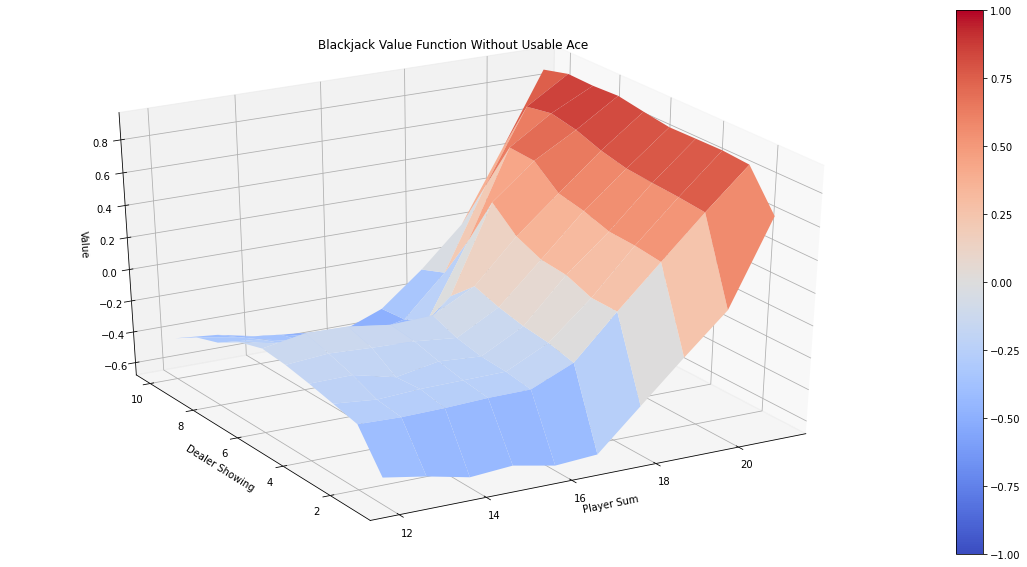

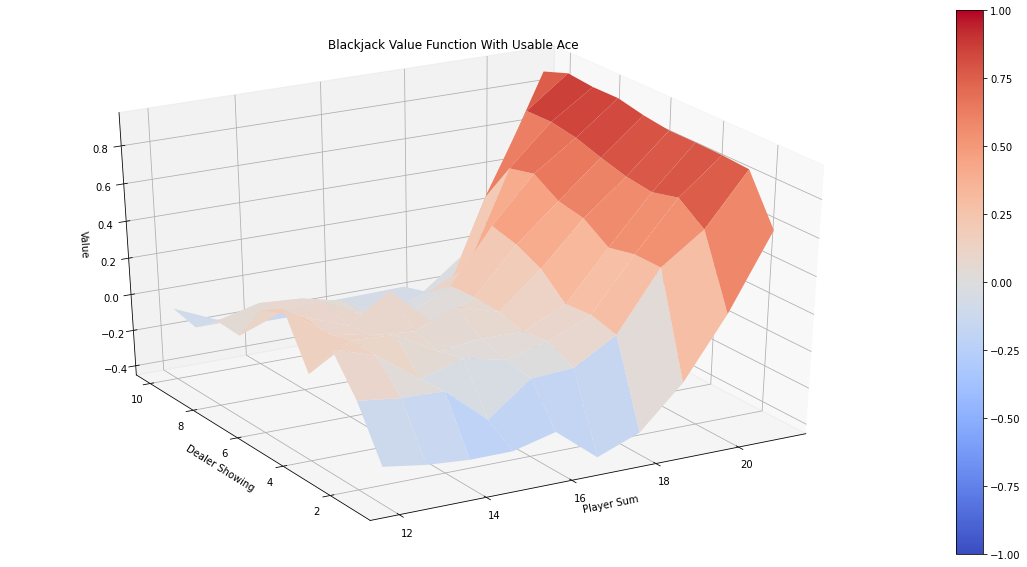

In [6]:
def plot_blackjack_value(V):
  player_sum_range = range(12, 22)
  dealer_show_range = range(1, 11)
  X, Y = torch.meshgrid([torch.tensor(player_sum_range), torch.tensor(dealer_show_range)])
  values_to_plot = torch.zeros((len(player_sum_range), len(dealer_show_range), 2))
  for i, player in enumerate(player_sum_range):
    for j, dealer in enumerate(dealer_show_range):
      for k, ace in enumerate([False, True]):
        values_to_plot[i, j, k] = V[(player, dealer, ace)]
  plot_surface(X, Y, values_to_plot[:,:,0].numpy(),"Blackjack Value Function Without Usable Ace")
  plot_surface(X, Y, values_to_plot[:,:,1].numpy(),"Blackjack Value Function With Usable Ace")
plot_blackjack_value(optimal_value)

# helpful resource

[Blackjack game](https://en.wikipedia.org/wiki/Blackjack)